## Describing EMS & Fire Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
ems_example_df = pd.read_csv(os.getenv('EMS_DATA_EXAMPLE_PATH'))
fire_example_df = pd.read_csv(os.getenv('FIRE_DATA_EXAMPLE_PATH'))


print("EMS DataFrame Info:")
print(ems_example_df.info())
print(ems_example_df.describe)

print("\nFire DataFrame Info:")
print(fire_example_df.info())
print(fire_example_df.describe)

EMS DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 11 columns):
 #   Column                                                                         Non-Null Count  Dtype 
---  ------                                                                         --------------  ----- 
 0   Response Incident Number (eResponse.03)                                        2369 non-null   int64 
 1   Response EMS Response Number (eResponse.04)                                    2365 non-null   object
 2   Response EMS Unit Call Sign (eResponse.14)                                     2369 non-null   object
 3   Response EMS Vehicle Unit Number (eResponse.13)                                2369 non-null   object
 4   Response Level Of Care Of This Unit (3.4=eResponse.15/3.5=itResponse.115)      2313 non-null   object
 5   Incident Unit Left Scene Date Time (eTimes.09)                                 1378 non-null   object
 6   Incident Uni

#### Average Response Time (FIRE)

Top 5 Incident Types:
Basic Incident Type (FD1.21)
Outside equipment fire                              21.566667
Search for person on land                           15.296726
Brush or brush-and-grass mixture fire (Wildland)    13.733333
Carbon monoxide incident                            13.179365
Sprinkler activation, no fire - unintentional       12.191667
Name: resp_mins, dtype: float64


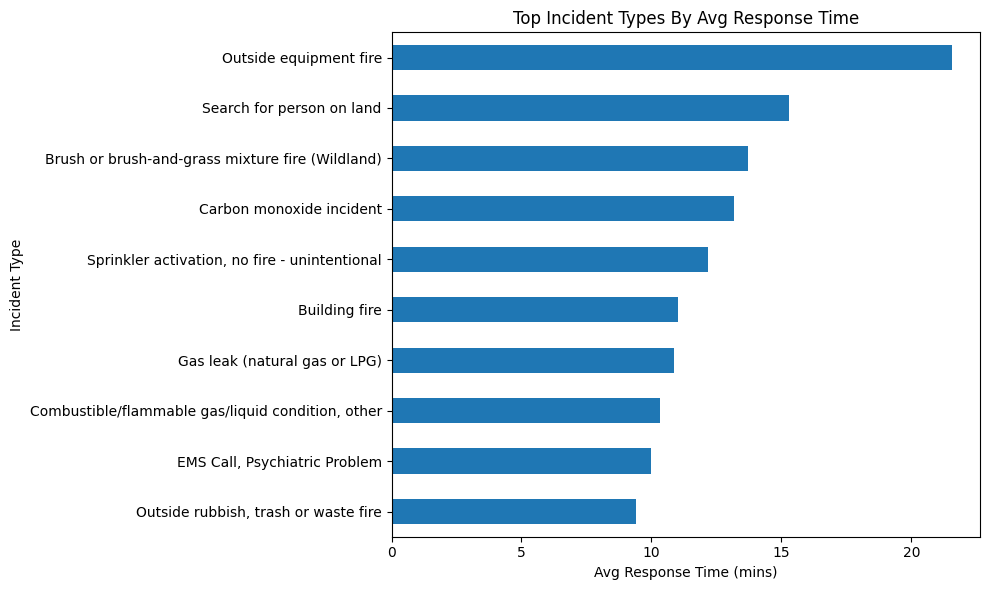

In [4]:
fire_example_df["dispatch_time"] = pd.to_datetime(fire_example_df["Apparatus Resource Dispatch Date Time (FD18.3)"], errors="coerce")
fire_example_df["arrive_time"] = pd.to_datetime(fire_example_df["Apparatus Resource Arrival Date Time (FD18.4)"], errors="coerce")

fire_example_df["resp_mins"] = (fire_example_df["arrive_time"] - fire_example_df["dispatch_time"]).dt.total_seconds() / 60

res = (
    fire_example_df.groupby("Basic Incident Type (FD1.21)")["resp_mins"]
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

print("Top 5 Incident Types:")
print(res.head())

plt.figure(figsize=(10,6))
res.head(10).plot(kind="barh")
plt.xlabel("Avg Response Time (mins)")
plt.ylabel("Incident Type")
plt.title("Top Incident Types By Avg Response Time")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Incidents By Week (FIRE)

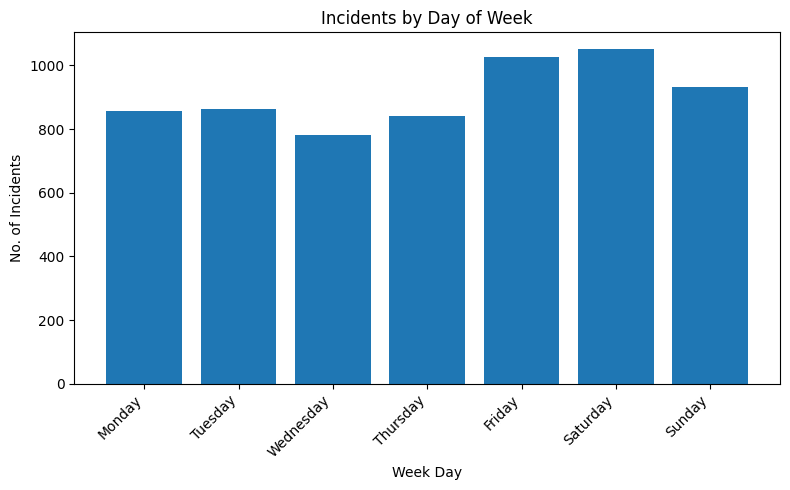

In [5]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day_stats = (fire_example_df["Basic Incident Day Name (FD1.3)"].value_counts().reindex(days_of_week, fill_value=0))

plt.figure(figsize=(8, 5))
plt.bar(day_stats.index, day_stats.values)
plt.xlabel("Week Day")
plt.ylabel("No. of Incidents")
plt.title("Incidents by Day of Week")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Resource Utilization (FIRE)


Resource Utilization:
                                           deployment_total  hours_total
Apparatus Resource Type Category (FD18.2)                               
Ground Fire Suppression                                3858  1435.302222
Medical & Rescue Unit                                  1866  1132.722222
Other                                                   558   335.326944
Support Equipment                                        45    28.299167
Heavy Ground Equipment                                    6     3.114722


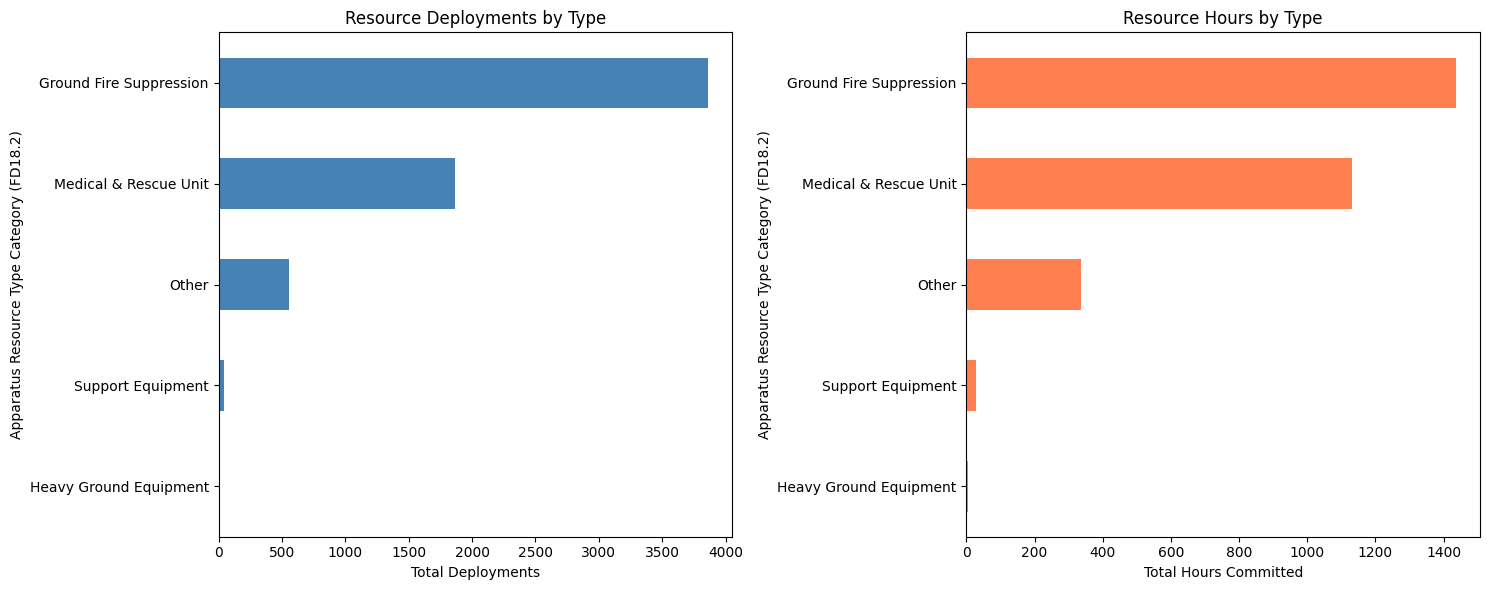

In [ ]:
fire_example_df["clear_time"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Clear Date Time (FD18.5)"], 
    errors="coerce"
)
fire_example_df["arrival_time"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Arrival Date Time (FD18.4)"], 
    errors="coerce"
)

fire_example_df["on_scene_time"] = (
    fire_example_df["clear_time"] - fire_example_df["arrival_time"]
).dt.total_seconds() / 60

resource_stats = (
    fire_example_df.groupby("Apparatus Resource Type Category (FD18.2)")
    .agg({
        "Apparatus Resource ID (FD18.1)": "count", "on_scene_time": "sum"
    })
    .rename(columns={"Apparatus Resource ID (FD18.1)": "deployment_total","on_scene_time": "hours_total"})
)


resource_stats.dropna(inplace=True)
resource_stats["hours_total"] = resource_stats["hours_total"] / 60
resource_stats = resource_stats.sort_values("deployment_total", ascending=False)

print("\nResource Utilization:")
print(resource_stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

resource_stats["deployment_total"].plot(kind="barh", ax=ax1, color="steelblue")
ax1.set_xlabel("Total Deployments")
ax1.set_title("Resource Deployments by Type")
ax1.invert_yaxis()

resource_stats["hours_total"].plot(kind="barh", ax=ax2, color="coral")
ax2.set_xlabel("Total Hours Committed")
ax2.set_title("Resource Hours by Type")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


### Peak Hour Analysis


 Peak Hour Analysis 

Mean incidents per hour: 264.58
Median incidents per hour: 282.50
Std deviation: 108.90

Peak hour: 11:00 with 431 incidents
Lowest hour: 3:00 with 93 incidents

Top 5 busiest hours:
  11:00 - 431 incidents (6.8%)
  13:00 - 422 incidents (6.6%)
  19:00 - 400 incidents (6.3%)
  20:00 - 390 incidents (6.1%)
  12:00 - 355 incidents (5.6%)

Bottom 5 quietest hours:
  3:00 - 93 incidents (1.5%)
  4:00 - 99 incidents (1.6%)
  5:00 - 103 incidents (1.6%)
  1:00 - 148 incidents (2.3%)
  0:00 - 163 incidents (2.6%)

 Time Period Distribution 

Overnight (11pm-6am): 934 incidents (14.7%)
Morning rush (6am-10am): 1009 incidents (15.9%)
Midday (10am-2pm): 1550 incidents (24.4%)
Afternoon rush (2pm-6pm): 1323 incidents (20.8%)
Evening (6pm-11pm): 1534 incidents (24.2%)


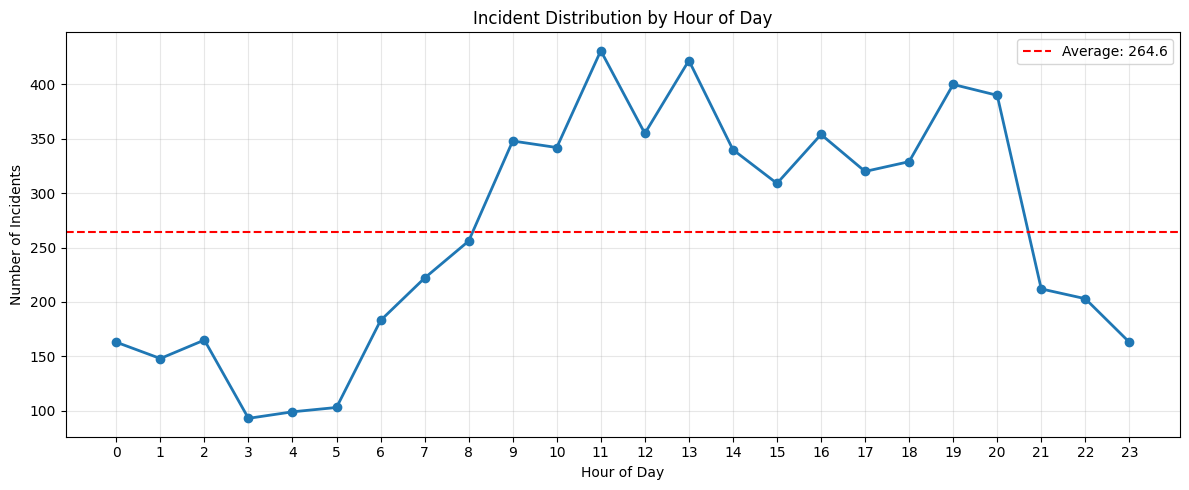

In [ ]:

fire_example_df["dispatch_dt"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Dispatch Date Time (FD18.3)"], 
    errors="coerce"
)
fire_example_df["hour"] = fire_example_df["dispatch_dt"].dt.hour

hourly_incidents = fire_example_df.groupby("hour").size()

print("\n Peak Hour Analysis \n")
print(f"Mean incidents per hour: {hourly_incidents.mean():.2f}")
print(f"Median incidents per hour: {hourly_incidents.median():.2f}")
print(f"Std deviation: {hourly_incidents.std():.2f}")
print(f"\nPeak hour: {hourly_incidents.idxmax()}:00 with {hourly_incidents.max()} incidents")
print(f"Lowest hour: {hourly_incidents.idxmin()}:00 with {hourly_incidents.min()} incidents")


print(f"\nTop 5 busiest hours:")

for hour, count in hourly_incidents.sort_values(ascending=False).head(5).items():
    print(f"  {hour}:00 - {count} incidents ({count/hourly_incidents.sum()*100:.1f}%)")
    
    
print(f"\nBottom 5 quietest hours:")
for hour, count in hourly_incidents.sort_values(ascending=True).head(5).items():
    print(f"  {hour}:00 - {count} incidents ({count/hourly_incidents.sum()*100:.1f}%)")


morning_rush = hourly_incidents[6:10].sum() #6 to 10am
midday = hourly_incidents[10:14].sum() #10am to 2pm
afternoon_rush = hourly_incidents[14:18].sum() #2pm to 6pm
evening = hourly_incidents[18:23].sum() #6pm to 11pm
overnight = hourly_incidents[list(range(0,6)) + [23]].sum() #11pm to 6am

print(f"\n Time Period Distribution \n")
print(f"Overnight (11pm-6am): {overnight} incidents ({overnight/hourly_incidents.sum()*100:.1f}%)")
print(f"Morning rush (6am-10am): {morning_rush} incidents ({morning_rush/hourly_incidents.sum()*100:.1f}%)")
print(f"Midday (10am-2pm): {midday} incidents ({midday/hourly_incidents.sum()*100:.1f}%)")
print(f"Afternoon rush (2pm-6pm): {afternoon_rush} incidents ({afternoon_rush/hourly_incidents.sum()*100:.1f}%)")
print(f"Evening (6pm-11pm): {evening} incidents ({evening/hourly_incidents.sum()*100:.1f}%)")

plt.figure(figsize=(12, 5))
plt.plot(hourly_incidents.index, hourly_incidents.values, marker='o', linewidth=2, markersize=6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Incidents")
plt.title("Incident Distribution by Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.axhline(y=hourly_incidents.mean(), color='r', linestyle='--', label=f'Average: {hourly_incidents.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()